# NCDS Project Notebook

## Packages

In [1]:
import pandas as pd
import pymysql
import logging
import sshtunnel
from sshtunnel import SSHTunnelForwarder
import os.path
import matplotlib.pyplot as plt
import numpy as np
import os 
from collections import Counter
from scipy.stats import gaussian_kde
from pandas import option_context
from IPython.display import display
from PIL import Image
import re
from wordcloud import WordCloud

## Open Connection

In [2]:
# You will need to add your SSH public key and database password to connect.
ssh_host = 'vfsmghnecweb01.fsm.northwestern.edu'
ssh_username = 'efa3001'
db_server = 'vfsmghnecdb01.fsm.northwestern.edu'
database_username = 'efa3001'
ssh_pkey = 'C:\\Users\\16262\\Desktop\\NCDS-NEC_Data_Internship\\5-16-privkey-openSSH'
database_password = 'E%H2)h.nPevc<a>&'
database_name = 'nec_dw'
localhost = '127.0.0.1'

In [3]:
def open_ssh_tunnel(verbose=False):
    """Open an SSH tunnel and connect using a username and password.
    
    :param verbose: Set to True to show logging
    :return tunnel: Global SSH tunnel connection
    """
    
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    
    global tunnel
    tunnel = SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_pkey,
        remote_bind_address = (db_server, 3306)
    )
    
    tunnel.start()

def mysql_connect():
    """Connect to a MySQL server using the SSH tunnel connection
    
    :return connection: Global MySQL database connection
    """
    
    global connection
    
    connection = pymysql.connect(
        host = localhost,
        user = database_username,
        passwd = database_password,
        db = database_name,
        port = tunnel.local_bind_port
    )
    
def run_query(sql):
    """Runs a given SQL query via the global database connection.
    
    :param sql: MySQL query
    :return: Pandas dataframe containing results
    """
    
    return pd.read_sql_query(sql, connection)

def mysql_disconnect():
    """Closes the MySQL database connection.
    """
    
    connection.close()
    
def close_ssh_tunnel():
    """Closes the SSH tunnel connection.
    """
    
    tunnel.close

In [4]:
open_ssh_tunnel()
mysql_connect()

## 1) Staff Activities: Relationship between Funding and Success Rating

In [5]:
staff = run_query("SELECT * FROM StaffActivities")
staff_success = staff[staff["ActivityHowSuccessfulID"] > 0.0]

In [6]:
#checking if each staff activity ID is unique...yes!
unique_act = staff_success["ActivityID"].unique()
len(unique_act)==len(staff_success)

True

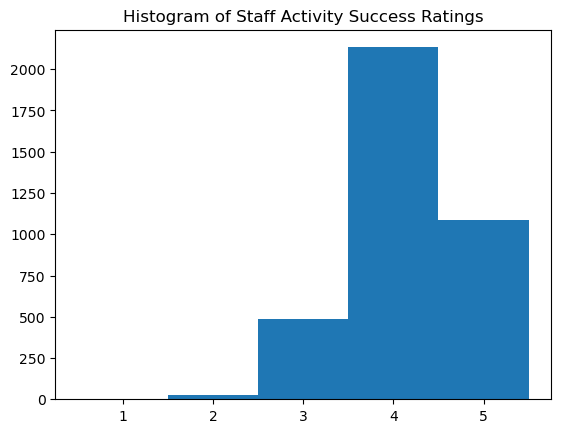

In [7]:
#distribution for success ratings in staff activities
plt.title("Histogram of Staff Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [staff_success["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

In [8]:
#looking at Activity ID, Success ID, and non-NLM funding
staff_success_funds = staff_success[["ActivityID","ActivityHowSuccessfulID","NonNLMFundingAmount"]]
staff_success_funds.head()

,ActivityID,ActivityHowSuccessfulID,NonNLMFundingAmount
0,9649,4.0,0.0
1,9664,4.0,0.0
2,9665,5.0,0.0
3,9666,5.0,0.0
4,9667,4.0,0.0


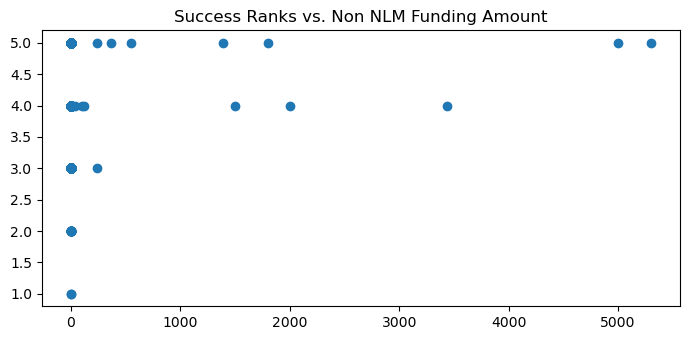

In [9]:
#for success rankings from 0 to 5
plt.title("Success Ranks vs. Non NLM Funding Amount")
plt.scatter(staff_success_funds["NonNLMFundingAmount"], staff_success_funds["ActivityHowSuccessfulID"])

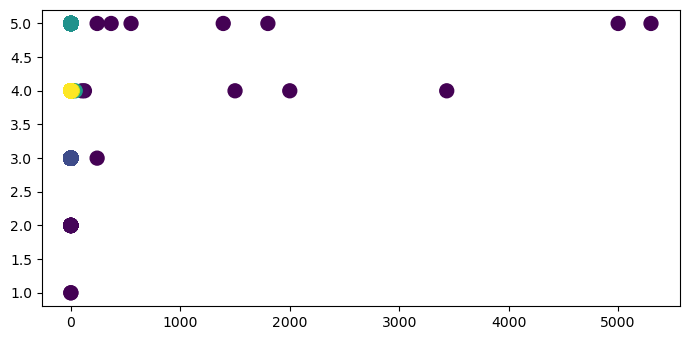

In [10]:
#generate density scatter plot
x = staff_success_funds["NonNLMFundingAmount"]
y = staff_success_funds["ActivityHowSuccessfulID"]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

#darker color = lower density
#lighter color = higher density

In [11]:
staff_describe_fund_success = staff_success_funds.groupby(["ActivityHowSuccessfulID"])["NonNLMFundingAmount"].describe()
staff_describe_fund_success

,count,mean,std,min,25%,50%,75%,max
ActivityHowSuccessfulID,,,,,,,,
1.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2.0,27.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,485.0,0.494845,10.897839,0.0,0.0,0.0,0.0,240.0
4.0,2133.0,3.383029,91.999761,0.0,0.0,0.0,0.0,3434.0
5.0,1087.0,13.477461,232.223901,0.0,0.0,0.0,0.0,5300.0


###### Most of the success ratings are skewed towards 4 or 5. For context, success ratings are determined by the group carrying out the project, so they may be biased. From the density plot and percentiles, it seems that most of the successful (4 or 5 rated) activities have no non-NLM funding. However, the mean and max of nonNLMFundingAmount seem to correlate with how successful the activity is rated. 

## 2) Subaward Activities: Relationship between Mean Activity Funding and Mean Activity Success Rating

In [12]:
#grabbing Subaward Activites, Projects, and Project Funding Tables
sub, sub_proj, sub_proj_fund = run_query("SELECT * FROM SubawardActivities"), run_query("SELECT * FROM Projects"), run_query("SELECT * FROM ProjectFunding")

In [13]:
sub.head(2)

,ActivityID,Title,RegionOfficeID,ProjectID,Description,StartDate,EndDate,Status,ActivityWasConductedOnline,ActivityWasConductedInPerson,...,TrainingWasProvided,AddressStreet,AddressApartmentSuite,AddressCity,AddressState,Zip,116CongressDistrict,GeocodedLatitude,GeocodedLongitude,ModifiedDate
0,9654,All of Us; New York-New Jersey Chapter of the ...,3,9630.0,The purpose of this activity was to present up...,2018-10-24,2018-10-24,Accept and Add Staff Data,0,1,...,0.0,33 West 42nd Street,,New York,NY,10036,None,None,None,2020-03-07
1,9822,2018 Shale & Public Health Conference,3,9687.0,This tabling activity was available from 9am-5...,2018-11-14,2018-11-14,Accept and Add Staff Data,0,1,...,0.0,123 University Place,,Pittsburgh,PA,15260,None,None,None,2020-03-07


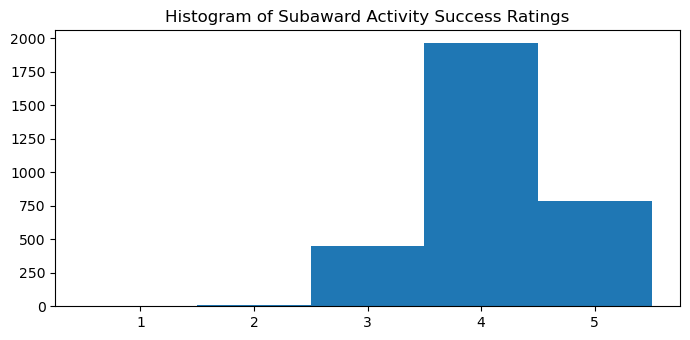

In [14]:
#distribution for success in subaward activities

plt.title("Histogram of Subaward Activity Success Ratings")
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
x = [sub["ActivityHowSuccessfulID"]]
my_bins = np.arange(6)+0.5
plt.hist(x, my_bins)
plt.show()

###### The distribution for subaward activity success ratings looks about the same as for the staff award activity success ratings.

In [15]:
#checking if a project has multiple activities...yes!
len(sub["ProjectID"].unique())<len(sub["ProjectID"])

True

In [16]:
#grouping activities to identify mean activity fundings within each project
mean_act_fund = sub_proj_fund.groupby(["ProjectID"])["FundingAmount"].mean().to_frame().rename(columns={"FundingAmount":"MeanFunding"})
proj_title = run_query("SELECT ProjectID, Title, ProjectSummary FROM Projects")
sub_proj_summ_and_fund = mean_act_fund.merge(proj_title, how = "left", on = "ProjectID")
sub_proj_summ_and_fund.head(2)

,ProjectID,MeanFunding,Title,ProjectSummary
0,9630,16070.0,All of Us - The All of Us Research Program and...,The National Institutes of Health and the Nati...
1,9651,4941.0,Seeds of Hope,The Clinton-Essex-Franklin Library System (CEF...


In [17]:
sub_success = run_query("SELECT ActivityID, ProjectID, ActivityHowSuccessfulID FROM SubawardActivities")
sub_success_pos = sub_success[sub_success["ActivityHowSuccessfulID"]>0]
sub_mean_success = sub_success_pos.groupby("ProjectID")["ActivityHowSuccessfulID"].mean().to_frame()
sub_fund_mean_success = sub_mean_success.merge(sub_proj_summ_and_fund, how = "inner", on = "ProjectID")
sub_fund_mean_success.sort_values("MeanFunding", ascending = False).head(3)

,ProjectID,ActivityHowSuccessfulID,MeanFunding,Title,ProjectSummary
416,30397.0,4.000000,261930.0,Citizen Science Month 2021,The Network of the National Library of Medicin...
419,31469.0,3.666667,163993.0,Health and Wellness Conversations at Your Library,StoryCorps and the National Network of Librari...
377,28243.0,4.000000,138805.5,AgriSafeHealthHub (AHH),The purpose of the NLM funded project is to cr...


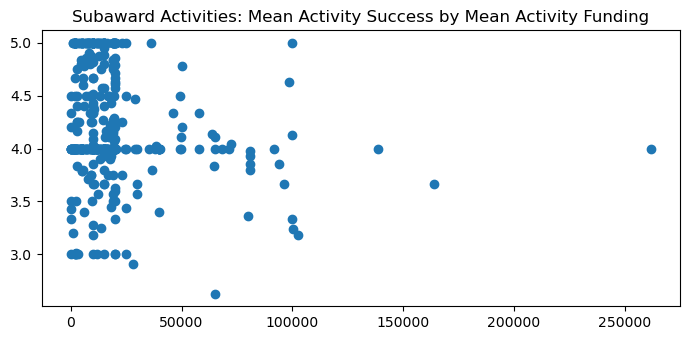

In [18]:
plt.title("Subaward Activities: Mean Activity Success by Mean Activity Funding")
plt.scatter(sub_fund_mean_success["MeanFunding"], sub_fund_mean_success["ActivityHowSuccessfulID"])

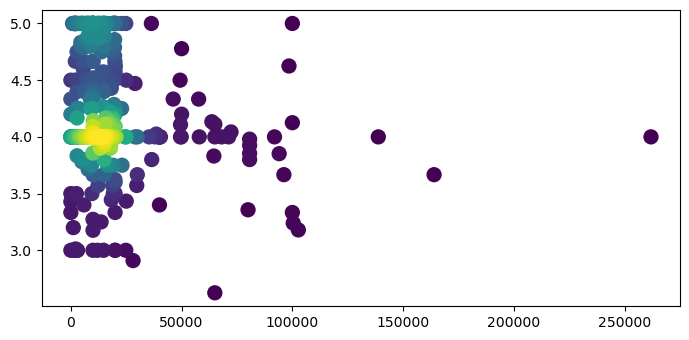

In [19]:
#generate density scatter plot
x1 = sub_fund_mean_success["MeanFunding"]
y1 = sub_fund_mean_success["ActivityHowSuccessfulID"]
xy1 = np.vstack([x1,y1])
z1 = gaussian_kde(xy1)(xy1)

idx1 = z1.argsort()
x1, y1, z1 = x1[idx1], y1[idx1], z1[idx1]

fig1, ax1 = plt.subplots()
ax1.scatter(x1, y1, c=z1, s=100)
plt.show()

#darker color = lower density
#lighter color = higher density

In [20]:
sub_fund_mean_success["RoundedSuccess"] = sub_fund_mean_success["ActivityHowSuccessfulID"].round(0)
sub_describe_fund_success = sub_fund_mean_success.groupby(["RoundedSuccess"])["MeanFunding"].describe()
sub_describe_fund_success

,count,mean,std,min,25%,50%,75%,max
RoundedSuccess,,,,,,,,
3.0,30.0,24519.816667,31782.670793,0.0,2500.00,12821.0,24952.5,102708.5
4.0,280.0,19829.758333,25720.839442,0.0,7975.75,15000.0,19880.5,261930.0
5.0,113.0,13192.044248,13783.880478,750.0,6710.00,10000.0,16127.0,100000.0


###### Similar to staff activities, the subaward activities are concentrated at a success rating of 4.0, on the lower scale of funding. It does not seem like funding has a clear relationship with the success rating of activitiess. Even higher-funded activities at the 100,000 range are spread across the 3 to 5 ratings, and activities above that range are only around the 4 rating.

## 3) Subaward Activities: Relationship between Mean Activity Funding and Descriptors

In [21]:
#top five and lowest five projects in funding (that are not 0)
sub_proj_summ_and_fund.sort_values("MeanFunding", ascending = False)[sub_proj_summ_and_fund["MeanFunding"] > 1]

,ProjectID,MeanFunding,Title,ProjectSummary
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021,DESCRIPTION: The mission of the National Netwo...
...,...,...,...,...
4453,1010929,6.600000e+01,Exhibitor: National MS Society Upstate New Yor...,DESCRIPTION: Funds will support The Capital Di...
1322,1002436,6.250000e+01,Exhibit Award: Minnesota-2002 Minnesota 4TH Te...,"DESCRIPTION: Exhibit Award: Lisa McGuire, Jame..."
1451,1002574,5.150000e+01,Exhibit Award - WXII Healthy Living Fair 2004,DESCRIPTION: Exhibit at the WXII Healthy Livin...
1809,1003032,3.750000e+01,Exhibit Award: 2002 American Indian Higher Edu...,DESCRIPTION: Exhibit Award: to exhibit at the ...


### A. Identifying Descriptors (Summary, Title)

In [22]:
sub_proj_unique = sub_proj_summ_and_fund
sub_proj_unique.sort_values("MeanFunding").head()

,ProjectID,MeanFunding,Title,ProjectSummary
5302,1016866,0.0,Partner Outreach 2018-2019: University of Illi...,DESCRIPTION: As part of the Professional Servi...
5209,1016306,0.0,Partner Outreach 2018-2021: University of Nort...,DESCRIPTION: To perform outreach on behalf of ...
1079,1002179,0.0,Houston AIDS Information Link (HAIL) 1998,DESCRIPTION: The Houston AIDS Information Link...
5210,1016307,0.0,Partner Outreach 2018-2021: University of Cinc...,DESCRIPTION: To perform outreach on behalf of ...
5298,1016848,0.0,All of Us; OU Tulsa Library Individualized Hea...,DESCRIPTION: The University of Oklahoma Tulsa-...


#### Creating a clean project summary

In [23]:
# Cleaning Function

def cleaner(newcol):
    """takes a column from a dataframe and cleans character and space formatting. 
    leaves words, spaces, and most punctuations"""
    
    # Convert to strings because of hidden non-characters
    newcol = \
    newcol.map(lambda x: str(x))

    # Encode as ASCII text and remove Unicode characters
    newcol = \
    newcol.map(lambda x: x.encode("ascii", "ignore"))

    newcol = \
    newcol.map(lambda x: x.decode())

    # Remove raw HTML
    newcol = \
    newcol.map(lambda x: re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', x))

    # Remove literal "\n" or "\n\n" from anywhere in the string
    newcol = \
    newcol.map(lambda x: re.sub(r'(?:\\n)+',' ', x))

    # Remove solo-hyphens
    newcol = \
    newcol.map(lambda x: re.sub(r'(\-\s|\s\-)', ' ', x))

    # Remove the white spaces that are leading and trailing
    newcol = \
    newcol.map(lambda x: x.strip())

    # Remove excess white space
    newcol = \
    newcol.map(lambda x: re.sub(r'( +)',' ', x))
    
    return newcol

def extraclean(col):
    """returns col in lowercase and without parentheses, asterisks, periods, commas, colons, and semi-colons"""
    
    # Remove parentheses, asterisks, periods, commas, colons and semi-colons
    col = \
    col.map(lambda x: re.sub(r'\(|\)|\.|\,|\:|\;|\*', '', x))

    # Convert the titles to lowercase
    col = \
    col.map(lambda x: x.lower())
    
    return col

In [24]:
sub_proj_unique["CleanSummary"] = sub_proj_unique["ProjectSummary"]
sub_proj_unique["CleanSummary"] = extraclean(cleaner(sub_proj_unique["CleanSummary"]))

# Print out the first rows
sub_proj_unique["CleanSummary"].head()

0    the national institutes of health and the nati...
1    the clinton-essex-franklin library system cefl...
2    to support community health nurses across the ...
3    southwest pennsylvania environmental health pr...
4    this project focuses on key health priorities ...
Name: CleanSummary, dtype: object

#### Creating a clean title

In [25]:
sub_proj_unique["CleanTitle"] = sub_proj_unique["Title"]
sub_proj_unique["CleanTitle"] = extraclean(cleaner(sub_proj_unique["CleanTitle"]))

sub_proj_unique["CleanTitle"].head()

0    all of us the all of us research program and p...
1                                        seeds of hope
2    resources and services for community health nu...
3    clinical and public health approaches for comm...
4                           arizona outreach 2016-2021
Name: CleanTitle, dtype: object

#### Finding proper nouns in the summary

In [26]:
sub_proj_unique["ProperNouns"] = sub_proj_unique["ProjectSummary"]
sub_proj_unique["ProperNouns"] = cleaner(sub_proj_unique["ProperNouns"])

# Remove "To", "The" and "This" from anywhere in the string
sub_proj_unique["ProperNouns"] = \
sub_proj_unique["ProperNouns"].map(lambda x: re.sub(r'The|This|To','', x))

# Remove excess white space (again)
sub_proj_unique["ProperNouns"] = \
sub_proj_unique["ProperNouns"].map(lambda x: re.sub(r' +',' ', x))

# Retain only proper nouns, but may split or delete some proper nouns.
sub_proj_unique["ProperNouns"] = \
sub_proj_unique["ProperNouns"].map(lambda x: re.findall(r'(?<![a-z]\.\s)\b([A-Z]\w+(?:[\s|\-|\/][A-Z]\w*)*)(?=[^\:])\b', x))

# Print out the first rows
sub_proj_unique.head()

,ProjectID,MeanFunding,Title,ProjectSummary,CleanSummary,CleanTitle,ProperNouns
0,9630,16070.0,All of Us - The All of Us Research Program and...,The National Institutes of Health and the Nati...,the national institutes of health and the nati...,all of us the all of us research program and p...,"[National Institutes, Health, National Library..."
1,9651,4941.0,Seeds of Hope,The Clinton-Essex-Franklin Library System (CEF...,the clinton-essex-franklin library system cefl...,seeds of hope,"[Clinton-Essex-Franklin Library System, CEFLS,..."
2,9683,20000.0,Resources and Services for Community Health Nu...,To support community health nurses across the ...,to support community health nurses across the ...,resources and services for community health nu...,"[State, Nevada, National Library, Medicine, NL..."
3,9687,16338.0,Clinical and Public Health Approaches for Comm...,Southwest Pennsylvania Environmental Health Pr...,southwest pennsylvania environmental health pr...,clinical and public health approaches for comm...,[Southwest Pennsylvania Environmental Health P...
4,9698,40445.5,Arizona Outreach (2016-2021),This project focuses on key health priorities ...,this project focuses on key health priorities ...,arizona outreach 2016-2021,"[Arizona, Hispanic, Spanish, Native American, ..."


#### WordCloud for Proper Nouns overall

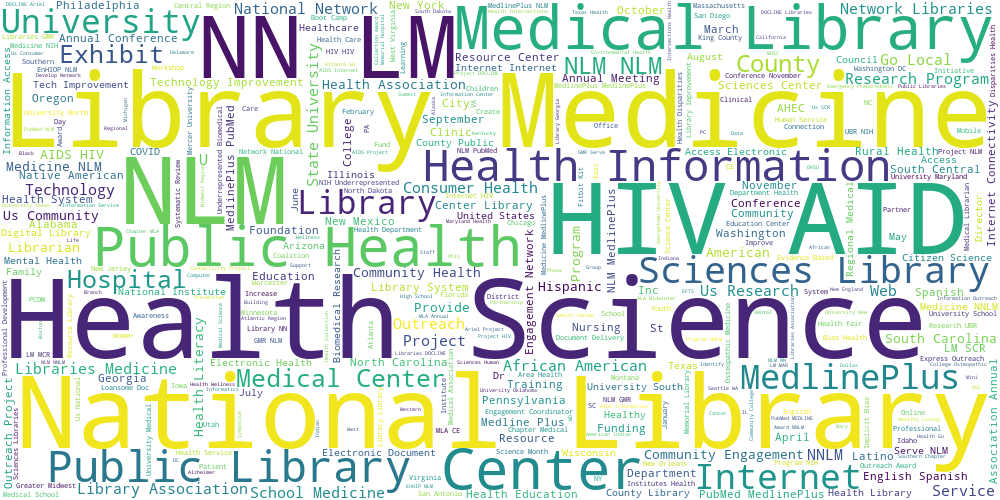

In [27]:
# Join the different processed titles together.
proper_noun_list = list(np.concatenate(sub_proj_unique['ProperNouns']).flat)
proper_string=(", ").join(proper_noun_list)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='green', width = 1000, height = 500)

# Generate a word cloud
wordcloud.generate(proper_string)

# Visualize the word cloud
wordcloud.to_image()

#print(proper_string)

#### Identifying the most common overall words in Clean Summary

In [28]:
common_words_list = Counter(" ".join(sub_proj_unique['CleanSummary']).split()).most_common(250)
filler_words = [tupleObj[0] for tupleObj in common_words_list]
#print(filler_words)

#### Removing most common overall words from Clean Summary to create Short Summary

In [29]:
#source: https://stackoverflow.com/questions/55533962/removing-specific-word-in-a-string-in-pandas
filler_words = set(filler_words)
drop = lambda x: ' '.join(w for w in x.split() if not w in filler_words)
sub_proj_unique['ShortSummary'] = sub_proj_unique['CleanSummary'].apply(drop)
sub_proj_unique.sort_values("MeanFunding", ascending = False).head(3)

,ProjectID,MeanFunding,Title,ProjectSummary,CleanSummary,CleanTitle,ProperNouns,ShortSummary
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair,DESCRIPTION: As one of the largest consumers o...,description as one of the largest consumers of...,connect to your health wellness fair,"[As, Connect, UR Health, Southampton, Stony Br...",largest senior adults often left behind techno...
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...,DESCRIPTION: The University of Maryland Health...,description the university of maryland health ...,national network of libraries of medicine sout...,"[University, Maryland Health Sciences, Human S...",maryland human regional 2006-2011 contract
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021",DESCRIPTION: The Gibson D. Lewis Health Scienc...,description the gibson d lewis health science ...,nn/lm south central region 2016-2021,"[Gibson D, Lewis Health Science Library, Unive...",gibson d lewis north texas unthsc regional med...


### B. Identifying Descriptors by Funding Category

#### Creating Bins to group by Mean Funding

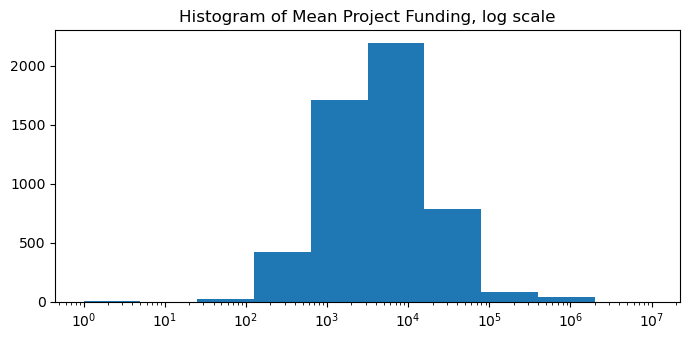

In [30]:
#create histogram to determine funding bins.
#source: https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib

def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(1),np.log10(10000000),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

plt.title("Histogram of Mean Project Funding, log scale")
x = [sub_proj_unique['MeanFunding']]

plot_loghist(x, 10)

In [31]:
#bins to sort the data into
funding_bins=(np.arange(11)+1)**6
print(funding_bins)

#note: mean funds of 1 and 0 will be grouped, 1 being most likely an error or null value.
sub_proj_unique[sub_proj_unique['MeanFunding']==1].head(3)

[      1      64     729    4096   15625   46656  117649  262144  531441
 1000000 1771561]


,ProjectID,MeanFunding,Title,ProjectSummary,CleanSummary,CleanTitle,ProperNouns,ShortSummary
2826,1004249,1.0,PSR Outreach Connections,"DESCRIPTION: This project highlights training,...",description this project highlights training d...,psr outreach connections,"[PubMed, MedlinePlus, NLM, Pacific Southwest R...",highlights demonstrations presentations and/or...
2887,1004325,1.0,Improving Access to HIV/AIDS Health Informatio...,DESCRIPTION: The goal of the STAR TRACK progra...,description the goal of the star track program...,improving access to hiv/aids health informatio...,"[STAR TRACK, HIV/AIDS, Baltimore, HIV/AIDS, HI...",star track prevent spread educating between ag...
2893,1004332,1.0,Improving HIV/AIDS Health Information Use and ...,DESCRIPTION: The goal of the SHINE (Statewide ...,description the goal of the shine statewide hi...,improving hiv/aids health information use and ...,"[SHINE, Statewide HIV/AIDS Information Network...",shine statewide affected previously funded 200...


In [32]:
def to_the_bin(num):
    """
    to assign a bin value for the number up to largest number in funding_bins.
    
    Arguments: a number, int or float
    
    Returns: bin value containing the number, upper bound. however, nums from 0 to (and including) 1 will be in the bin 0.
    
    """
    cap = 0
    count = 0
    for y in funding_bins:
        count+=1
        if (num > y):
            cap = funding_bins[count]
    return cap

In [33]:
sub_proj_unique["FundingBin"] = sub_proj_unique["MeanFunding"].apply(to_the_bin)

In [34]:
descr_fund_bins = sub_proj_unique.groupby(['FundingBin'])["MeanFunding"].describe()
descr_fund_bins

,count,mean,std,min,25%,50%,75%,max
FundingBin,,,,,,,,
0,62.0,1.129032e-01,0.319058,0.000000e+00,0.000,0.000000e+00,0.000000e+00,1.000000e+00
64,4.0,4.525000e+01,14.660036,2.950000e+01,35.500,4.450000e+01,5.425000e+01,6.250000e+01
729,485.0,4.157662e+02,168.874977,6.600000e+01,250.000,4.640000e+02,5.090000e+02,7.285000e+02
4096,1809.0,1.813337e+03,774.409800,7.340000e+02,1222.000,1.655000e+03,2.099000e+03,4.092000e+03
15625,2045.0,8.688366e+03,3719.139004,4.100000e+03,5000.000,7.790600e+03,1.200000e+04,1.551000e+04
46656,650.0,2.529321e+04,7971.391504,1.567200e+04,19727.000,2.334650e+04,2.933388e+04,4.650000e+04
117649,193.0,6.818111e+04,20169.251997,4.674600e+04,50000.000,6.000000e+04,8.071000e+04,1.176114e+05
262144,22.0,1.699865e+05,43965.949721,1.178367e+05,138448.875,1.610902e+05,1.954642e+05,2.619300e+05
531441,8.0,3.467877e+05,58584.054094,2.899380e+05,313302.500,3.252300e+05,3.582310e+05,4.646757e+05


#### Identifying the most common summary words in each funding group

In [35]:
clean_sum_bins = sub_proj_unique[["FundingBin", "CleanTitle", "ShortSummary"]]

In [36]:
def key_words(df, col):
    """
    joins the specified (col) column cells for each group, 
    and identifies the ten most common words in that group.
    
    to use: df.groupby(...).apply(common_word, col = '...')
    
    arguments: pd dataframe, string column name
    
    returns: a list of tuples of the ten most common words 
    for this group and their counts.
    """
    common_list = Counter(" ".join(df[col]).split()).most_common(10)
    return (common_list)

In [37]:
unique_words = clean_sum_bins.groupby(['FundingBin']).apply(key_words, col = 'ShortSummary').to_frame()
unique_words.rename(columns={unique_words.columns[0]:'SummaryKeyWords'}, inplace=True)

title_words = clean_sum_bins.groupby(['FundingBin']).apply(key_words, col = 'CleanTitle').to_frame()
title_words.rename(columns={title_words.columns[0]:'TitleKeyWords'}, inplace=True)

In [38]:
keys_count = unique_words.merge(descr_fund_bins, how = "left", on = "FundingBin").merge(title_words, how = "left", on = "FundingBin")[["SummaryKeyWords", "TitleKeyWords","count"]].rename(columns = {"count":"NumberProjects"})

pd.set_option("max_colwidth", None)
keys_count

,SummaryKeyWords,TitleKeyWords,NumberProjects
FundingBin,,,
0,"[(gmr, 38), (behalf, 37), (offering, 25), (promotion, 25), (citizen, 13), (perform, 11), (environmental, 8), (aids, 7), (presentations, 7), (student, 7)]","[(library, 42), (of, 41), (outreach, 40), (university, 33), (partner, 25), (2018-2021, 21), (health, 21), (2018-2019, 13), (2017-2018, 13), (the, 12)]",62.0
64,"[(wallace, 2), (professionaltargetpophpstudents, 2), (winston-salem, 2), (nc, 2), (addajane, 1), (creating, 1), (documents, 1), (palm, 1), (os, 1), (handhelds, 1)]","[(award, 4), (exhibit, 3), (professional, 1), (development, 1), (halifax, 1), (medical, 1), (center, 1), (minnesota-2002, 1), (minnesota, 1), (4th, 1)]",4.0
729,"[(professionaltargetpoppharmn, 71), (professionaltargetpophpstudents, 62), (mla, 41), (searching, 39), (2006, 38), (april, 37), (carolina, 36), (october, 32), (professionaltargetpophpstudentsn, 30), (fair, 29)]","[(award, 295), (exhibit, 141), (professional, 104), (development, 103), (health, 91), (of, 83), (training, 78), (library, 72), (association, 61), (medical, 54)]",485.0
4096,"[(nih, 150), (october, 142), (software, 116), (i, 110), (funds, 101), (selected, 100), (evidence-based, 95), (institutions, 94), (connectivity, 94), (ariel, 93)]","[(award, 930), (health, 506), (library, 448), (of, 395), (exhibit, 352), (development, 285), (professional, 280), (and, 240), (university, 198), (medical, 197)]",1809.0
15625,"[(children, 157), (counties, 155), (subcontract, 141), (minority, 138), (environmental, 137), (texas, 136), (curriculum, 132), (group, 132), (family, 131), (citizen, 131)]","[(health, 1016), (outreach, 543), (library, 495), (and, 486), (of, 448), (information, 407), (for, 366), (award, 365), (project, 324), (the, 321)]",2045.0
46656,"[(series, 75), (covid-19, 68), (build, 67), (practices, 66), (centers, 66), (over, 65), (developed, 63), (subcontract, 61), (existing, 58), (hiv, 58)]","[(health, 341), (information, 161), (and, 160), (for, 142), (the, 118), (to, 116), (of, 113), (outreach, 110), (project, 108), (in, 97)]",650.0
117649,"[(hiv, 41), (aids, 40), (engagement, 33), (following, 30), (coordinate, 29), (mcr, 28), (native, 26), (citizen, 25), (supports, 25), (collaborations, 24)]","[(health, 78), (library, 56), (of, 49), (information, 43), (project, 37), (community, 33), (the, 27), (for, 25), (resource, 25), (and, 24)]",193.0
262144,"[(mcr, 14), (engagement, 13), (game, 11), (evaluation, 7), (departments, 6), (ndco, 6), (ahh, 5), (practices, 5), (agrisafe, 5), (citizen, 5)]","[(health, 11), (of, 9), (library, 9), (information, 5), (public, 4), (and, 4), (access, 4), (the, 3), (to, 3), (outreach, 3)]",22.0
531441,"[(evaluation, 16), (neo, 9), (rml, 6), (departments, 5), (aim, 5), (effective, 3), (continuing, 3), (consultation, 3), (planning, 3), (contract, 3)]","[(center, 4), (outreach, 3), (evaluation, 3), (national, 2), (resource, 2), (web, 2), (services, 2), (office, 2), (2016-2021, 2), (of, 2)]",8.0


In [39]:
pd.reset_option('display.max_colwidth')

In [40]:
#combine key summaries for all projects per bin
all_title = clean_sum_bins.groupby(['FundingBin'])['CleanTitle'].apply(' '.join).reset_index()
all_sum = clean_sum_bins.groupby(['FundingBin'])['ShortSummary'].apply(' '.join).reset_index()

all_keys = all_title.merge(all_sum, on = "FundingBin").merge(keys_count['NumberProjects'], on = "FundingBin")

all_keys

,FundingBin,CleanTitle,ShortSummary,NumberProjects
0,0,partner outreach 2018-2021 southern illinois u...,offering promotion behalf gmr offering promoti...,62.0
1,64,professional development award halifax medical...,addajane wallace creating documents palm os ha...,4.0
2,729,exhibit 189 remote area medical ram volunteer ...,remote ram volunteer corps wise va july 2018 k...,485.0
3,4096,american university of health sciences trainin...,four six-hour mini-academy lesson auhs first a...,1809.0
4,15625,seeds of hope supporting the rn explorers prog...,clinton-essex-franklin cefls plattsburgh york ...,2045.0
5,46656,all of us the all of us research program and p...,institutes partnered engaging around preconfer...,650.0
6,117649,increasing awareness of and engagement in citi...,citizen game day citizen engage users includes...,193.0
7,262144,human genetics film series for public librarie...,engagement cec been awarded amount $181857 pil...,22.0
8,531441,library improvement project knollwood hospital...,bank computers alabama williams thomas twillia...,8.0
9,1000000,greater midwest region south central region co...,rml contract pilastnamejacobson pifirstnamesus...,10.0


In [41]:
#count number of words in each bin
all_keys["TitleCount"] = all_keys["CleanTitle"].apply(str.count, args = (" "))+1
all_keys["SumCount"] = all_keys["ShortSummary"].apply(str.count, args = (" "))+1

all_keys

,FundingBin,CleanTitle,ShortSummary,NumberProjects,TitleCount,SumCount
0,0,partner outreach 2018-2021 southern illinois u...,offering promotion behalf gmr offering promoti...,62.0,564,1190
1,64,professional development award halifax medical...,addajane wallace creating documents palm os ha...,4.0,28,78
2,729,exhibit 189 remote area medical ram volunteer ...,remote ram volunteer corps wise va july 2018 k...,485.0,3605,9444
3,4096,american university of health sciences trainin...,four six-hour mini-academy lesson auhs first a...,1809.0,14577,45927
4,15625,seeds of hope supporting the rn explorers prog...,clinton-essex-franklin cefls plattsburgh york ...,2045.0,18303,80068
5,46656,all of us the all of us research program and p...,institutes partnered engaging around preconfer...,650.0,5561,31322
6,117649,increasing awareness of and engagement in citi...,citizen game day citizen engage users includes...,193.0,1468,8145
7,262144,human genetics film series for public librarie...,engagement cec been awarded amount $181857 pil...,22.0,179,789
8,531441,library improvement project knollwood hospital...,bank computers alabama williams thomas twillia...,8.0,50,246
9,1000000,greater midwest region south central region co...,rml contract pilastnamejacobson pifirstnamesus...,10.0,50,212


In [59]:
def cloud_gen(bin_num, df, col):
    
    """generates a word cloud for the specific funding bin."""

    barriers_num = ' '.join(list(df[df['FundingBin'] == bin_num][col].values))
    
    return (WordCloud(background_color="white", 
                max_words=20, 
                contour_width=3, 
                contour_color='red', 
                colormap = 'Set1',
                scale = 1).generate(barriers_num).to_image())

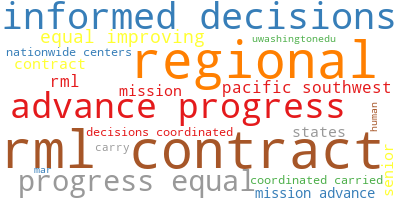

In [60]:
cloud_gen(1771561, all_keys, "ShortSummary")

### C. Identifying Unique Problems/Barriers Per Funding Bin

In [44]:
rep = run_query("SELECT * FROM Reports")[["ProjectID","ProblemsOrBarriersEncountered"]]
rep_bar = rep[rep.ProblemsOrBarriersEncountered.astype(bool)]
bar_and_fund = rep_bar.merge(mean_act_fund, how = "inner", on = "ProjectID")
bar_and_fund.head()

,ProjectID,ProblemsOrBarriersEncountered,MeanFunding
0,17166,<p>OHAI only discovered two major barriers or ...,5000.0
1,17139,<p>Our public health and health sciences libra...,96184.0
2,17136,<p>A limited number of staff working on the NN...,98483.0
3,17060,<p>This did not apply to my professional devel...,1500.0
4,17057,<p>This did not apply to my professional devel...,1500.0


#### Cleaning Problems or Barriers Encountered

In [45]:
bar_and_fund["CleanProblems"] = bar_and_fund["ProblemsOrBarriersEncountered"]
bar_and_fund["CleanProblems"] = extraclean(cleaner(bar_and_fund["CleanProblems"]))

bar_and_fund["CleanProblems"]

0      ohai only discovered two major barriers or pro...
1      our public health and health sciences libraria...
2      a limited number of staff working on the nnlm ...
3      this did not apply to my professional developm...
4      this did not apply to my professional developm...
                             ...                        
501    as a result of the pandemic sacramento county ...
502    covid was our main barrier as it prevented us ...
503    this project was submitted and awarded in the ...
504    this project was planned prior to the pandemic...
505    pretests were planned but we were not able to ...
Name: CleanProblems, Length: 506, dtype: object

In [46]:
def common_list (dfcol, n):
    """
    identifies the most common n words in the entire column
    
    """
    comlist = Counter(" ".join(dfcol).split()).most_common(n)
    comlist = [tupleObj[0] for tupleObj in comlist]
    return (comlist)

def drop_words(text, comlist):
    """
    removes comlist words from the string of interest
    
    """
    to_drop = set(comlist)
    return (' '.join(w for w in text.split() if not w in to_drop))

In [47]:
#list of common terms in overall barriers, mostly filler words
bar_filler = common_list(bar_and_fund['CleanProblems'], 26)

bar_filler

['the',
 'to',
 'and',
 'of',
 'in',
 'a',
 'we',
 'was',
 'for',
 'were',
 'with',
 'that',
 'this',
 'our',
 'not',
 'as',
 'on',
 'project',
 'library',
 'had',
 'at',
 'be',
 'have',
 'health',
 'it',
 'is']

In [48]:
#drop filler words from cleaned problems
bar_and_fund['ShortProblem'] = bar_and_fund['CleanProblems'].apply(drop_words, comlist = bar_filler)

bar_and_fund['ShortProblem']

0      ohai only discovered two major barriers or pro...
1      public sciences librarians created engaging co...
2      limited number staff working nnlm all us commu...
3            did apply my professional development award
4            did apply my professional development award
                             ...                        
501    result pandemic sacramento county placed diffe...
502    covid main barrier prevented us from conductin...
503    submitted awarded early days covid 19 pandemic...
504    planned prior pandemic when pandemic began phy...
505    pretests planned but able implement due time c...
Name: ShortProblem, Length: 506, dtype: object

#### Identifying Common Barriers Overall

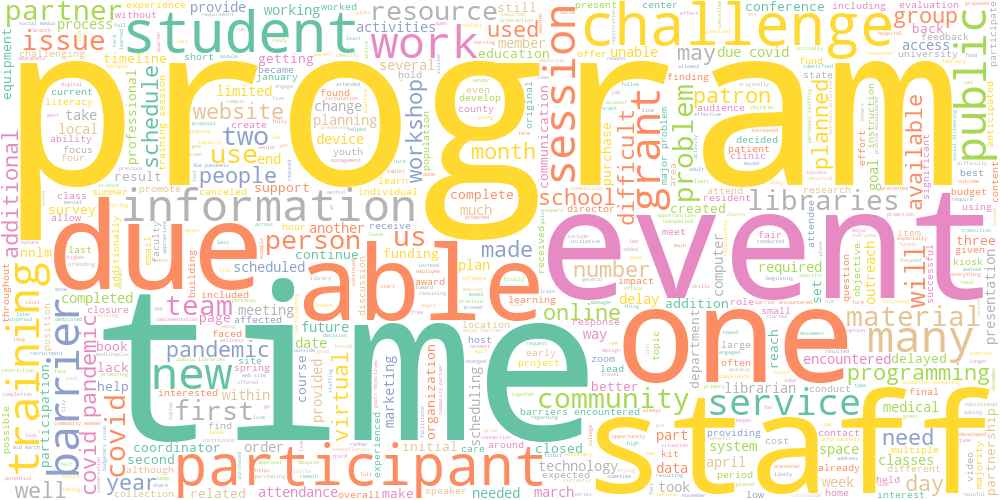

In [49]:
# Join the different processed titles together.
overall_barriers = ','.join(list(bar_and_fund['ShortProblem'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='red', colormap = 'Set2', width = 1000, height = 500)

# Generate a word cloud
wordcloud.generate(overall_barriers)

# Visualize the word cloud
wordcloud.to_image()

#### Common Barriers by Funding Level

In [50]:
bar_and_fund["FundingBin"] = bar_and_fund["MeanFunding"].apply(to_the_bin)
unique_bar = bar_and_fund.groupby(['FundingBin']).apply(key_words, col = 'ShortProblem').to_frame()
unique_bar = unique_bar.merge(bar_and_fund.groupby(['FundingBin']).count()['ProjectID'], on = 'FundingBin').rename(columns={0:'KeyBarriers', 'ProjectID':'NumProjs'})

In [51]:
pd.set_option("max_colwidth", None)

unique_bar

,KeyBarriers,NumProjs
FundingBin,,
0,"[(outreach, 17), (i, 17), (staff, 11), (are, 11), (public, 11), (materials, 10), (time, 10), (from, 10), (librarian, 10), (year, 9)]",16
729,"[(are, 7), (i, 5), (agreement, 5), (time, 4), (they, 4), (no, 4), (them, 4), (what, 3), (best, 3), (check, 3)]",10
4096,"[(staff, 55), (due, 53), (has, 51), (covid-19, 48), (time, 48), (events, 46), (been, 46), (or, 46), (but, 44), (all, 44)]",110
15625,"[(time, 148), (from, 138), (program, 118), (all, 114), (community, 111), (their, 111), (would, 108), (an, 108), (or, 107), (training, 106)]",224
46656,"[(time, 89), (their, 83), (all, 82), (from, 82), (covid-19, 75), (due, 74), (program, 72), (staff, 70), (by, 67), (but, 65)]",113
117649,"[(all, 41), (public, 39), (time, 39), (one, 38), (programs, 37), (staff, 35), (program, 35), (or, 33), (an, 33), (community, 32)]",31
262144,"[(team, 8), (work, 6), (due, 4), (their, 4), (both, 3), (2020, 3), (pandemic, 3), (from, 3), (ucm, 3), (list, 3)]",2


In [52]:
pd.reset_option('display.max_colwidth')

In [53]:
#combine problems for all projects per bin
all_bar = bar_and_fund.groupby(['FundingBin'])['ShortProblem'].apply(' '.join).reset_index()

#count number of words in each problem
all_bar["ShortWordCount"] = all_bar["ShortProblem"].apply(str.count, args = (" "))+1

all_bar

,FundingBin,ShortProblem,ShortWordCount
0,0,one problem occurred year covid-19 pandemic im...,1383
1,729,- main problem slml encountered one group regu...,326
2,4096,did apply my professional development award di...,7703
3,15625,ohai only discovered two major barriers or pro...,22308
4,46656,collaborative effort various partners coordina...,14316
5,117649,public sciences librarians created engaging co...,5406
6,262144,team unable fully complete planned due several...,243


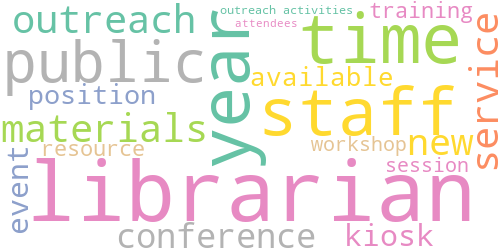

In [54]:
def cloud_gen(bin_num, df, col):
    
    """generates a word cloud for the specific funding bin"""

    barriers_num = ','.join(list(df[df['FundingBin'] == bin_num][col].values))
    
    return (WordCloud(background_color="white", 
              max_words=20, 
              contour_width=3, 
              contour_color='red', 
              colormap = 'Set2', 
              width = 500, 
              height = 250).generate(barriers_num).to_image())

cloud_gen(0, all_bar, 'ShortProblem')

## 4) Subaward Activities: Zip Codes and Mean Activity Funding

In [55]:
sub_geog = sub[['ActivityID', 'Title', 'ProjectID','Zip', 'County', 'AddressState', 'StartDate', 'EndDate']]
proj_occurr = pd.DataFrame(sub['ProjectID'].value_counts())
proj_occurr.reset_index(inplace=True)
proj_occurr = proj_occurr.rename(columns = {'index':'ProjectID', 'ProjectID': 'ActivityCount'})
sub_geog = sub_geog.merge(proj_occurr, on = 'ProjectID')
sub_geog['ProjectID'] = sub_geog['ProjectID'].astype('int64').astype('object')

total_proj_funding = sub_proj_fund.groupby('ProjectID').sum()['FundingAmount']
sub_geog = sub_geog.merge(total_proj_funding, on = 'ProjectID').rename(columns={'FundingAmount':'TotalProjFund'})

#"ApproxFunding" is the mean activity fund by project
sub_geog['ApproxFunding'] = sub_geog['TotalProjFund']/sub_geog['ActivityCount']
sub_geog.head(3)

,ActivityID,Title,ProjectID,Zip,County,AddressState,StartDate,EndDate,ActivityCount,TotalProjFund,ApproxFunding
0,9654,All of Us; New York-New Jersey Chapter of the ...,9630,10036,New York,NY,2018-10-24,2018-10-24,3,16070.0,5356.666667
1,11918,All of Us; The All of Us Research Program and ...,9630,12207,Albany,NY,2019-02-26,2019-02-26,3,16070.0,5356.666667
2,16342,All of Us; The All of Us Research Program and ...,9630,14604,Monroe,NY,2018-11-07,2018-11-07,3,16070.0,5356.666667


In [56]:
#to create a file for Tableau visualizations

# file_path = "C:\\Users\\16262\\Desktop\\ncds"

# if not os.path.exists(file_path):
#      os.mkdir(file_path)

# output_file = 'NNLM_SubawardActivities_and_Zip.tsv'
# complete_fn = os.path.join(file_path, output_file)
# sub_geog_df.to_csv(complete_fn, sep = '\t',index=False)

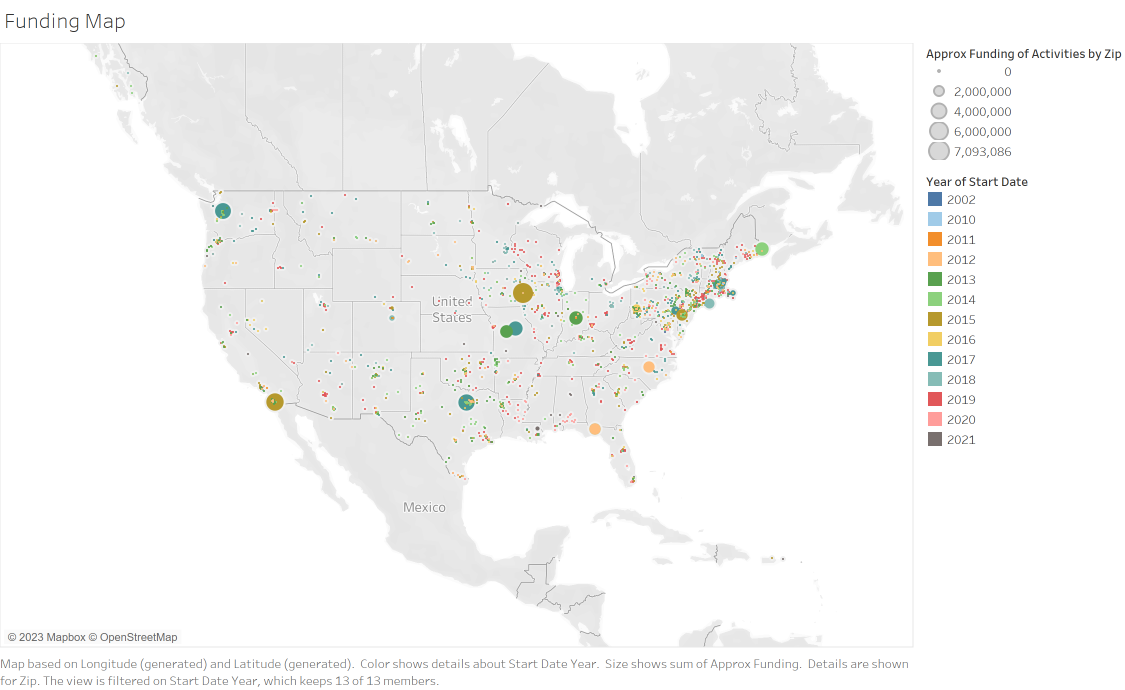

In [57]:
path="C:/Users/16262/Desktop/ncds/Funding_Map.png"
display(Image.open(path))

## Subaward Activities: Funding by Region

## Close Connection

In [58]:
mysql_disconnect()
close_ssh_tunnel()